In [1]:
#!pip install plotly --upgrade
#!pip install ipywidgets

# basic function

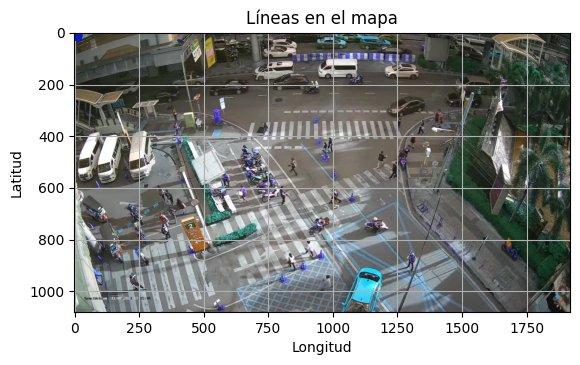

In [2]:
import matplotlib.pyplot as plt
import random
import cv2

def plot_lines_on_map(lines, color1=None, title=None):
    fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
    fondo = cv2.imread(fondo)
    
    if color1 is None:
        color1 = (random.random(), random.random(), random.random())

    if title is None:
        title = 'Líneas en el mapa'

    # Graficar las líneas en el mapa
    for line_points in lines:
        # Extraer las coordenadas de latitud y longitud de cada punto en la línea
        latitudes, longitudes = zip(*line_points)
        
        # Graficar la línea usando matplotlib
        plt.plot(longitudes, latitudes, color=color1, marker='o')

    # Guardar el gráfico de matplotlib
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.imshow(fondo)
    plt.title(title)
    plt.grid(True)
    plt.savefig('lineas_en_mapa.png')
    plt.show()


# Example data for three lines with different points
line1 = [(0, 0), (1, 1), (2, 2), (3, 3)]
line2 = [(4, 4), (5, 5), (6, 6)]
line3 = [(7, 7), (8, 8), (9, 9), (10, 10), (11, 11)]

# Plot the lines on the map
lines_to_plot = [line1, line2, line3]
plot_lines_on_map(lines_to_plot)

# read data features for each vehicle and save in file each coodinates

In [3]:
import pickle
import os
import pandas as pd

all_lines = []
all_names = []

all_dataframe = {} 

directorio = "/serverstorage/dataset_tailandia"
contenido_directorio = list(sorted([ f for f in os.listdir(directorio) if f.find("csv") > 0 ]))

for file in contenido_directorio:
    
    # Ruta del archivo CSV
    ruta_archivo_csv = directorio + "/" + file
    
    # Leer el archivo CSV y crear un DataFrame
    dataframe = pd.read_csv(ruta_archivo_csv)
    all_dataframe[file.split(".")[0]] = dataframe

    line = list(zip( dataframe["original_coordinate_x"], dataframe["original_coordinate_y"] ))
    all_lines.append(line)
    all_names.append(file.split(".")[0])
    
    # Mostrar el DataFrame
    # dataframe.head()
    

with open("/serverstorage/dataset_tailandia/calibration_dataset.pkl", 'wb') as file:
    pickle.dump([all_lines, all_names], file)

# process for find similar trayectory

In [45]:
from scipy.spatial.distance import directed_hausdorff
from collections import defaultdict
from itertools import chain


def get_semejantes(todas_las_lineas, umbral_similitud = 45):
    # Diccionario para almacenar las distancias de Hausdorff entre cada par de líneas
    distancias_hausdorff = {}

    # Calcular la distancia de Hausdorff entre cada par de líneas
    for i, linea_a in enumerate(todas_las_lineas):
        for j, linea_b in enumerate(todas_las_lineas):
            if i != j:  # Evitar comparar una línea consigo misma
                distancia = directed_hausdorff(linea_a, linea_b)[0]
                distancias_hausdorff[(i, j)] = distancia



    # Encontrar las líneas semejantes basadas en el umbral
    lineas_semejantes = []
    for par, distancia in distancias_hausdorff.items():
        if distancia < umbral_similitud:
            linea_a_idx, linea_b_idx = par
            lineas_semejantes.append((linea_a_idx, linea_b_idx))

    # Mostrar el resultado de las líneas semejantes
    pares_semejantes = []
    for idx_a, idx_b in lineas_semejantes:
        # print(f"\tLínea {idx_a + 1} es semejante a Línea {idx_b + 1}")
        pares_semejantes.append([idx_a + 1, idx_b + 1])
        
        
    # *********************************************************************************
    # usando un grafo saco todos los puntos que se unen

    
    # Crear un grafo utilizando un diccionario defaultdict
    grafo = defaultdict(list)
    for a, b in pares_semejantes:
        grafo[a].append(b)
        grafo[b].append(a)

    # Función para encontrar la componente conectada desde un nodo dado
    def encontrar_componente_conectada(nodo, grafo):
        visitados = set()
        componente = set()
        pila = [nodo]

        while pila:
            actual = pila.pop()
            if actual not in visitados:
                visitados.add(actual)
                componente.add(actual)
                pila.extend(grafo[actual])

        return componente

    # Encontrar todas las componentes conectadas del grafo
    componentes_conectadas = []
    visitados = set()
    for nodo in grafo:
        if nodo not in visitados:
            componente = encontrar_componente_conectada(nodo, grafo)
            componentes_conectadas.append(componente)
            visitados.update(componente)

    # Convertir las componentes conectadas en una lista de listas
    lineas_semejantes_lista = [list(componente) for componente in componentes_conectadas]
    
    return lineas_semejantes_lista

# functions for graph and export graph

In [5]:
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
from PIL import Image
import numpy as np


def print_graph(lineas_semejantes_lista, todas_las_lineas):
    fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
    fondo = cv2.imread(fondo)

    radius = 5
    thickness = 5

    for j, group in enumerate(lineas_semejantes_lista):
        color1 = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        group_lines = []
        for id in group:
            group_lines.append(todas_las_lineas[id-1])

        for coordinates in group_lines:

            for i, coordinate in enumerate(coordinates):
                fondo = cv2.circle(fondo, coordinate, radius, color1, thickness)

            for i, coordinate in enumerate(coordinates[:-1]):
                desde = coordinate
                hasta = coordinates[i+1]
                fondo = cv2.line(fondo, desde, hasta , color1, thickness )

    plt.figure(figsize=(20,8))
    plt.title(f'Movimientos actuales del vehiculo')
    plt.imshow(fondo)
    plt.show()
    

def export_graph(lineas_semejantes_lista):
    imagen_path = "/serverstorage/Tailandia/Tailandia 001.jpg"
    img = Image.open(imagen_path)
    img_array = np.array(img)

    fig = go.Figure()
    fig.add_trace(go.Image(z=img_array))  # image for background

    for j, group in enumerate(lineas_semejantes_lista):
        line_color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        group_lines = []
        group_names = []
        for id in group:
            group_lines.append(all_lines[id-1])
            group_names.append(all_names[id-1])

        for i, line_points in enumerate(group_lines):
            x_coords, y_coords = zip(*line_points)
            name = group_names[i]
            fig.add_trace(go.Scatter(x=x_coords, y=y_coords, mode='markers+lines', name=f'{j}-{name}', line=dict(color=f'rgb{line_color}')))

    fig.update_layout(title='Líneas sobre la imagen')
    pyo.plot(fig, filename='/serverstorage/interactive_image2.html')

# read file with each coordinates

In [32]:
all_lines, all_names = None, None

with open("/serverstorage/dataset_tailandia/calibration_dataset.pkl", 'rb') as archivo:
    all_lines, all_names = pickle.load(archivo)
    
#part_start = 0
#part_end = -1
#all_lines, all_names = all_lines[part_start:part_end],  all_names[part_start:part_end]
    
    
print(len(all_lines), len(all_names))
    
# quitando los que se consideran anomalia

anomalies = {
    "0082": None,
    "0130": None,
    "0317": None,
    "0326": None,
    }

for name_delete in anomalies.keys():
    if name_delete in all_names:
        index = all_names.index(name_delete)
        if index >= 0:
            all_names.remove(name_delete)
            anomalies[name_delete] = all_lines.pop(index)
            print(f"remove {name_delete}")
    
print(len(all_lines), len(all_names))

170 170
remove 0082
remove 0130
remove 0317
remove 0326
166 166


# See Cluster's search visually in a graph 

In [30]:
sensibility = 50  # High number = less clusters, low number = more cluster

Cantidad de cluster de comportamiento:  5


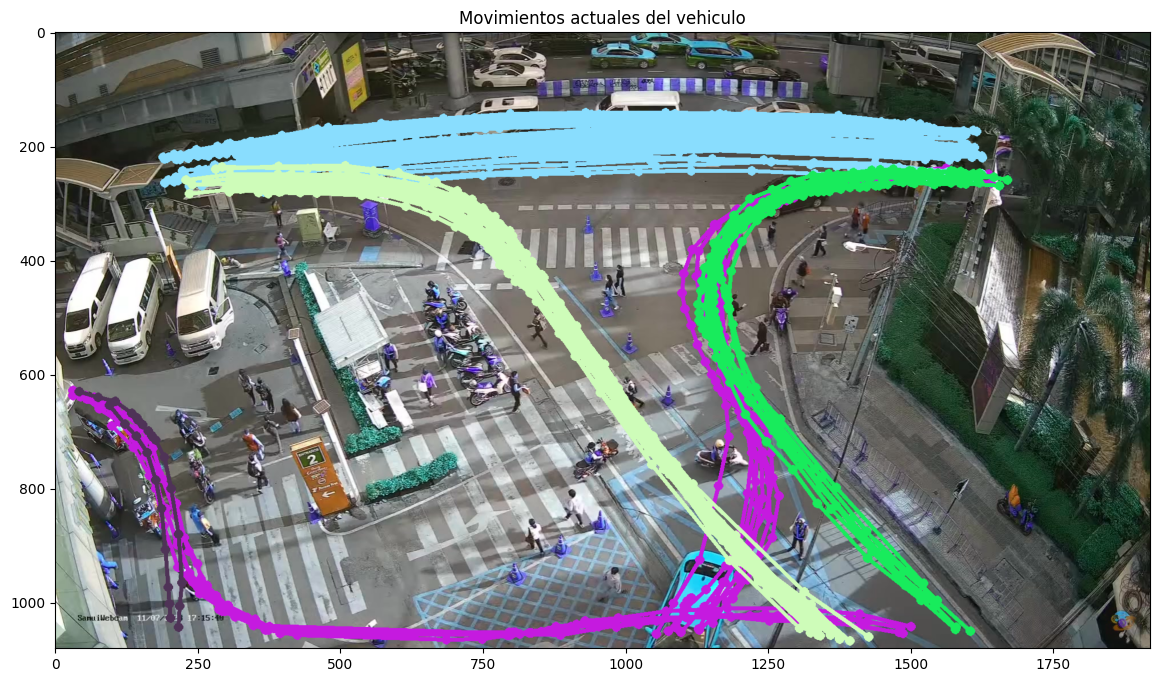

In [31]:
lineas_semejantes_lista = get_semejantes(all_lines, sensibility)
print("Cantidad de cluster de comportamiento: ", len(lineas_semejantes_lista))

print_graph(lineas_semejantes_lista, all_lines)
export_graph(lineas_semejantes_lista)

0 [1, 2, 3, 68, 106, 84, 85, 22, 21, 152, 153, 148, 28]
1 [4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 30, 31, 34, 36, 37, 39, 41, 42, 43, 44, 46, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 69, 73, 75, 76, 77, 78, 79, 80, 81, 82, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 128, 129, 130, 131, 135, 137, 138, 139, 140, 144, 145, 146, 147, 149, 151, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]
2 [65, 35, 132, 38, 10, 74, 83, 52]
3 [133, 12, 141, 142, 14, 13, 150, 32, 33, 40, 47, 48, 49, 51, 66, 70, 71, 72, 90, 91, 112, 113, 120, 127]
4 [45, 23]


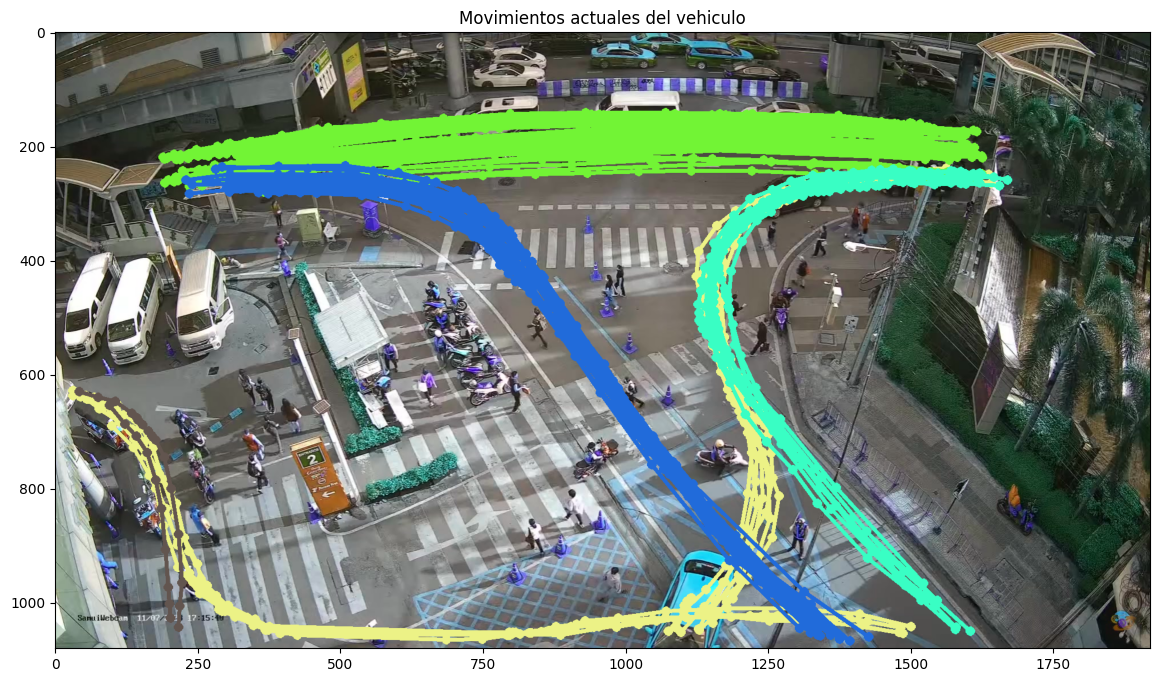

In [28]:
new_lines = []
new_names = []

MIN_SIZE = 0 # 12
MAX_SIZE = None # 30 # None


real_similars = []


for id_cluster, ids_vehicles in enumerate(lineas_semejantes_lista):
    real_ids = []
    for i in ids_vehicles:
        size_rows = len(all_lines[i-1])
        if size_rows >= MIN_SIZE:
            if MAX_SIZE is not None:
                if size_rows<=MAX_SIZE:
                    real_ids.append(i)
            else:
                real_ids.append(i)
            
    real_similars.append(real_ids)
    
for id_cluster, ids_vehicles in enumerate(real_similars):
    print(id_cluster, ids_vehicles)
    
print_graph(real_similars, all_lines)
export_graph(real_similars)

In [44]:


class ClusterAlgoritmia:
    
    lineas_semejantes_lista = []
    trained = False
    
    def __init__(self, sensibility):
        self.sensibility = sensibility
    
    def train(self, all_lines):
        self.all_lines = all_lines
    
    def predict(self, new_vehicles):
        predictions = []
        for new_vehicle in new_vehicles:
            all_lines = self.all_lines
            before = len(all_lines)
            all_lines.append(new_vehicle)
            after = len(all_lines)
            self.lineas_semejantes_lista = get_semejantes(all_lines, self.sensibility)
            self.trained = True
            for i, similar_list in enumerate(self.lineas_semejantes_lista):
                if after in similar_list:
                    predictions.append(i)   
        return predictions
            
    @property
    def brothers(self, cluster):
        if self.trained:
            return self.lineas_semejantes_lista[cluster]
         
        return []
        
sensibility = 50  # High number = less clusters, low number = more cluster
        
k_william = ClusterAlgoritmia(sensibility)
k_william.train(all_lines)
cluster = k_william.predict([anomalies["0326"]])
print(cluster)
print(k_william.brothers)


IndexError: tuple index out of range